In [1]:
import os
import sys
import argparse

import cv2
import torch
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.ops import nms
from typing import List

sys.path.insert(0, '../lib')
sys.path.insert(0, '../model')
from data.Coco import COCODataset
from utils import misc_utils, visual_utils

def ml_nms(boxlist, nms_th, max_num):
    boxes = boxlist[:,:4]
    scores = boxlist[:,4]
    labels = boxlist[:,5]
    result_mask = scores.new_zeros(scores.size(), dtype=torch.bool)
    for id in torch.jit.annotate(List[int], torch.unique(labels).cpu().tolist()):
        mask = (labels == id).nonzero(as_tuple=False).view(-1)       
        keep = nms(boxes[mask], scores[mask], nms_th)
        result_mask[mask[keep]] = True
    keep = result_mask.nonzero(as_tuple=False).view(-1)
    keep = keep[scores[keep].argsort(descending=True)]
    if len(keep) > max_num:
        keep = keep[:max_num]
    return keep

/home/jinhan/miniconda3/envs/odam/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load model

In [6]:
# model base config
# model_dir = 'fcos_regular'
model_dir = 'rcnn_regular' # if rcnn

model_root_dir = os.path.join('../model/', model_dir)
sys.path.insert(0, model_root_dir)
from config_bdd import config
# from config_coco import config
from network import Network

# load data
img_folder = config.eval_folder
source = config.eval_source
coco = COCODataset(config, img_folder, source, is_train=False) 
print(coco.__len__())

config.drise_output_format = False
# model_file = '../model/fcos_regular/coco_model/dump-12.pth'
model_file = '../../models/FasterRCNN_C4_BDD100K.pth' # if rcnn

# 'fpn', 'resnet_p3(p4,p5)'
# config.dam_feature = 'fpn'

# load model
net = Network(config)
net.eval()
net.cuda()
check_point = torch.load(model_file, map_location=torch.device('cpu'))
net.load_state_dict(check_point['model'], strict=False)

_IncompatibleKeys(missing_keys=['resnet50.conv1.weight', 'resnet50.bn1.weight', 'resnet50.bn1.bias', 'resnet50.bn1.running_mean', 'resnet50.bn1.running_var', 'resnet50.layer1.0.downsample.0.weight', 'resnet50.layer1.0.downsample.1.weight', 'resnet50.layer1.0.downsample.1.bias', 'resnet50.layer1.0.downsample.1.running_mean', 'resnet50.layer1.0.downsample.1.running_var', 'resnet50.layer1.0.conv1.weight', 'resnet50.layer1.0.bn1.weight', 'resnet50.layer1.0.bn1.bias', 'resnet50.layer1.0.bn1.running_mean', 'resnet50.layer1.0.bn1.running_var', 'resnet50.layer1.0.conv2.weight', 'resnet50.layer1.0.bn2.weight', 'resnet50.layer1.0.bn2.bias', 'resnet50.layer1.0.bn2.running_mean', 'resnet50.layer1.0.bn2.running_var', 'resnet50.layer1.0.conv3.weight', 'resnet50.layer1.0.bn3.weight', 'resnet50.layer1.0.bn3.bias', 'resnet50.layer1.0.bn3.running_mean', 'resnet50.layer1.0.bn3.running_var', 'resnet50.layer1.1.conv1.weight', 'resnet50.layer1.1.bn1.weight', 'resnet50.layer1.1.bn1.bias', 'resnet50.layer1.1.

In [4]:
net.FPN

RCNN(
  (fc1): Linear(in_features=12544, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (pred_cls): Linear(in_features=1024, out_features=11, bias=True)
  (pred_delta): Linear(in_features=1024, out_features=44, bias=True)
)

In [3]:
# get data and inference
img_path = './coco/images/val2017/000000049269.jpg'

img_id = int(os.path.basename(img_path)[:-4])
image, im_info, ID, anno, image_ori = coco.__getitem_from_ID__(img_id)

print(image.shape)
print(image_ori.shape)
print(im_info)
image_ori = cv2.cvtColor(image_ori,cv2.COLOR_RGB2BGR)  

# inference
# pred_boxes: x1,y1,x2,y2,score,tag, reg
# levels: boxes are predicted from which level
pred_boxes,features,levels = \
    net(image.unsqueeze(0).cuda(), im_info.unsqueeze(0).cuda())

# NMS
keep = ml_nms(pred_boxes, 0.5, 100) #config.test_nms, config.max_boxes_of_image
pred_boxes = pred_boxes[keep]
levels = levels[keep].squeeze()

scale_y, scale_x = im_info[2:4]
pred_boxes[:, 0:4:2] /= scale_x
pred_boxes[:, 1:4:2] /= scale_y

torch.Size([3, 1187, 800])
(640, 431, 3)
tensor([1187.0000,  800.0000,    1.8547,    1.8561,  640.0000,  431.0000])


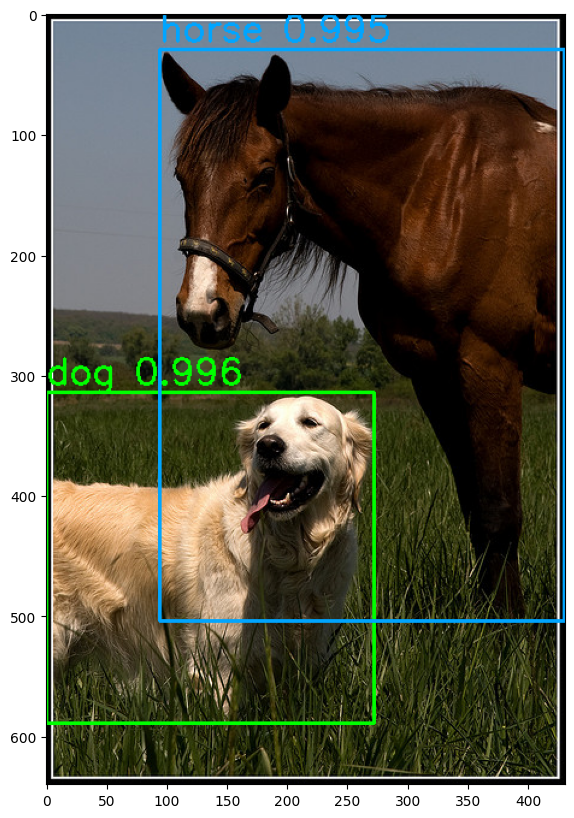

In [4]:
# visulization
boxes = pred_boxes.clone().detach().cpu()  
keep = boxes[:, 4] > 0.6
vis_boxes = boxes[keep].numpy()
vis_tags = vis_boxes[:, 5].astype(np.int32).flatten()
vis_tags_name = np.array(config.class_names)[vis_tags]

image_with_box = visual_utils.draw_boxes(
        image_ori.copy(),
        vis_boxes[:, :4],
        scores=vis_boxes[:, 4],
        tags=vis_tags_name,
            line_thick=2, line_color=None)
plt.figure(figsize=(10, 10))
plt.imshow(image_with_box[:,:,::-1])

In [5]:
eps = torch.finfo(torch.float32).eps
h,w,_ = image_ori.shape
resize = transforms.Resize([h,w]) 
show_num = min(2, len(pred_boxes))

feats = features['fpn']
pred_scores = pred_boxes[:, 4]
pred_regs = pred_boxes[:, 6:]
odam_maps = []
if show_num > 0:
    for i, box in enumerate(pred_boxes[:show_num]):
        fm = feats[levels[i]]
        out_score = pred_scores[i]
        out_left = pred_regs[i, 0]
        out_top = pred_regs[i, 1]
        out_right = pred_regs[i, 2]
        out_bottom = pred_regs[i, 3]

        tmp = []
        for out in [out_score, out_left, out_top, out_right, out_bottom]:
            grad = torch.autograd.grad(out, fm, retain_graph=True)[0]
            odam_map = F.relu_((grad * fm).sum(1))
            odam_map = resize(odam_map.detach()).squeeze(0)
            odam_map = (odam_map - odam_map.min()) / (odam_map.max() - odam_map.min()).clamp(min=eps)
            tmp.append(odam_map.cpu())
        odam_maps.append(tmp)
        

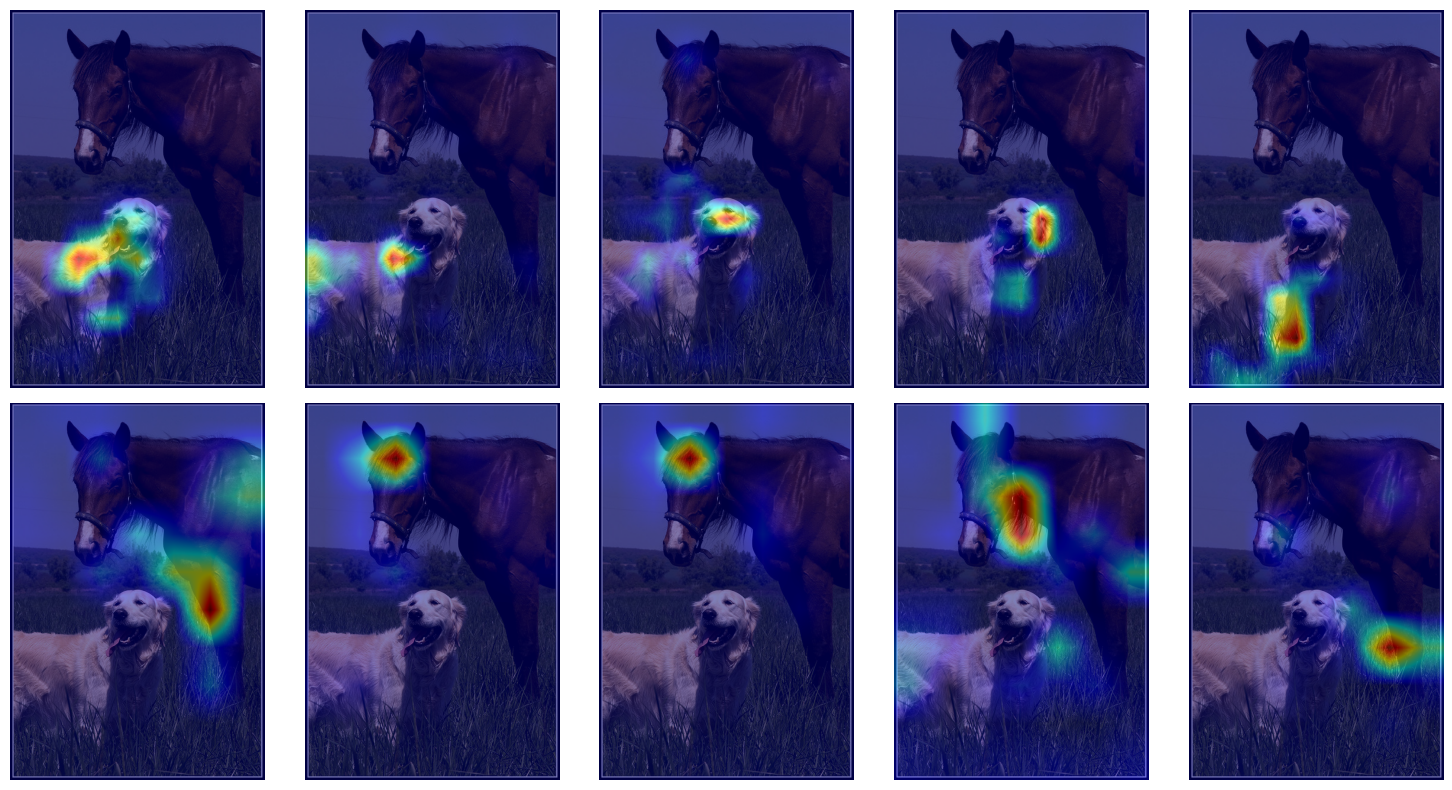

In [6]:
import cv2 
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(15, 8))

for j, ax_i, (m1, m2, m3, m4, m5) in zip(range(show_num), axs, odam_maps):
    for i, att in enumerate((m1, m2, m3, m4, m5)):
        att = att.numpy()*255.
        im_copy = image_ori.copy()
    
        ax = ax_i[i]
        ax.axis('off')
        color = cv2.applyColorMap(att.astype(np.uint8), cv2.COLORMAP_JET)[:,:,::-1]  # cv2 to plt
        c_ret = np.clip(im_copy[:,:,::-1] * (1 - 0.5) + color * 0.5, 0, 255).astype(np.uint8)
        ax.imshow(c_ret)   
        # ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
        #                            fill=False, color='blue', linewidth=3))
 
fig.tight_layout()
